In [1]:
import os
import numpy as np
import cv2
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

c:\Users\Priyank Kapadia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("lmslms/ufo-120")

print("Path to dataset files:", path)

100%|██████████| 227M/227M [01:22<00:00, 2.88MB/s] 

Extracting files...


Path to dataset files: C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1


In [3]:
for root, dirs, files in os.walk(path):
    print(root)

train_val_dir = os.path.join(path, "UFO-120", "train_val")

#all possible directories
possible_hr_dirs = ["hr", "HR"]
possible_lr_dirs = ["lrd", "LR", "lr"]

hr_dir = None
lr_dir = None

for d in possible_hr_dirs:
    candidate = os.path.join(train_val_dir, d)
    if os.path.exists(candidate):
        hr_dir = candidate
        break

for d in possible_lr_dirs:
    candidate = os.path.join(train_val_dir, d)
    if os.path.exists(candidate):
        lr_dir = candidate
        break

if hr_dir and lr_dir:
    print(f"HR directory: {hr_dir}")
    print(f"LR directory: {lr_dir}")
else:
    raise FileNotFoundError("HR or LR folder not found in train_val directory.")

# to ensure that the directories are not empty
if len(os.listdir(hr_dir)) == 0 or len(os.listdir(lr_dir)) == 0:
    raise ValueError("HR or LR folder is empty.")
else:
    print(f"HR images: {len(os.listdir(hr_dir))}, LR images: {len(os.listdir(lr_dir))}")


C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1
C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1\UFO-120
C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1\UFO-120\TEST
C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1\UFO-120\TEST\hr
C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1\UFO-120\TEST\lrd
C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1\UFO-120\TEST\mask
C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1\UFO-120\train_val
C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1\UFO-120\train_val\hr
C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1\UFO-120\train_val\lrd
C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\ufo-120\versions\1\UFO-120\train_val\mask
HR directory: C:\Users\Priyank Kapadia\.cache\kagglehub\datasets\lmslms\uf

In [4]:
img_size = 128
lr_size = 32

def load_images(hr_dir, lr_dir):
    hr_images, lr_images = [], []
    for fname in sorted(os.listdir(hr_dir)):
        hr_path = os.path.join(hr_dir, fname)
        lr_path = os.path.join(lr_dir, fname)
        if os.path.exists(lr_path):
            hr_img = cv2.imread(hr_path)
            hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
            hr_img = cv2.resize(hr_img, (img_size, img_size)) / 255.0

            lr_img = cv2.imread(lr_path)
            lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)
            lr_img = cv2.resize(lr_img, (lr_size, lr_size)) / 255.0

            hr_images.append(hr_img)
            lr_images.append(lr_img)
    return np.array(hr_images, dtype=np.float32), np.array(lr_images, dtype=np.float32)

hr_data, lr_data = load_images(hr_dir, lr_dir)
print(f"HR shape: {hr_data.shape}, LR shape: {lr_data.shape}")

X_train_lr, X_val_lr, X_train_hr, X_val_hr = train_test_split(lr_data, hr_data, test_size=0.1, random_state=42)

HR shape: (1500, 128, 128, 3), LR shape: (1500, 32, 32, 3)


# GENERATOR

In [5]:
from tensorflow.keras import layers

def residual_block(x):
    res = layers.Conv2D(64, 3, padding='same')(x)
    res = layers.BatchNormalization()(res)
    res = layers.PReLU(shared_axes=[1,2])(res)
    res = layers.Conv2D(64, 3, padding='same')(res)
    res = layers.BatchNormalization()(res)
    return layers.Add()([x, res])

def build_generator():
    inputs = layers.Input(shape=(lr_size, lr_size, 3))
    x = layers.Conv2D(64, 9, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1,2])(x)
    skip = x

    for _ in range(8):
        x = residual_block(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, skip])

    for _ in range(2):
        x = layers.Conv2D(256, 3, padding='same')(x)
        x = layers.UpSampling2D()(x)
        x = layers.PReLU(shared_axes=[1,2])(x)

    outputs = layers.Conv2D(3, 9, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs, outputs, name="Generator")

generator = build_generator()
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │     15,616 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ p_re_lu[0][0],    │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ p_re_lu_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ add[0][0],        │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]  

 Total params: 1,448,835 (5.53 MB)

 Trainable params: 1,446,659 (5.52 MB)

 Non-trainable params: 2,176 (8.50 KB)

# DISCRIMINATOR

In [6]:
def disc_block(x, filters, stride=1, bn=True):
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    if bn: x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    return x

def build_discriminator():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = disc_block(inputs, 64, bn=False)
    x = disc_block(x, 64, stride=2)
    x = disc_block(x, 128)
    x = disc_block(x, 128, stride=2)
    x = disc_block(x, 256)
    x = disc_block(x, 256, stride=2)
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs, name="Discriminator")

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 68,259,649 (260.39 MB)

 Trainable params: 68,257,985 (260.38 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [7]:
discriminator.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                      loss='binary_crossentropy')

discriminator.trainable = False

lr_inp = layers.Input(shape=(lr_size, lr_size, 3))
sr_out = generator(lr_inp)
validity = discriminator(sr_out)

srgan = tf.keras.Model(lr_inp, [sr_out, validity], name="SRGAN")
srgan.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=['mse', 'binary_crossentropy'],
              loss_weights=[1.0, 1e-3])

In [8]:
EPOCHS = 5
BATCH_SIZE = 8
real_labels = np.ones((BATCH_SIZE, 1))
fake_labels = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    for i in range(0, len(X_train_lr), BATCH_SIZE):
        lr_batch = X_train_lr[i:i+BATCH_SIZE]
        hr_batch = X_train_hr[i:i+BATCH_SIZE]

        sr_imgs = generator.predict(lr_batch)

        d_loss_real = discriminator.train_on_batch(hr_batch, real_labels[:len(hr_batch)])
        d_loss_fake = discriminator.train_on_batch(sr_imgs, fake_labels[:len(sr_imgs)])
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        g_loss = srgan.train_on_batch(lr_batch, [hr_batch, real_labels[:len(lr_batch)]])

    print(f"Epoch {epoch+1}/{EPOCHS} | D Loss: {d_loss:.4f} | G Loss: {g_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


c:\Users\Priyank Kapadia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


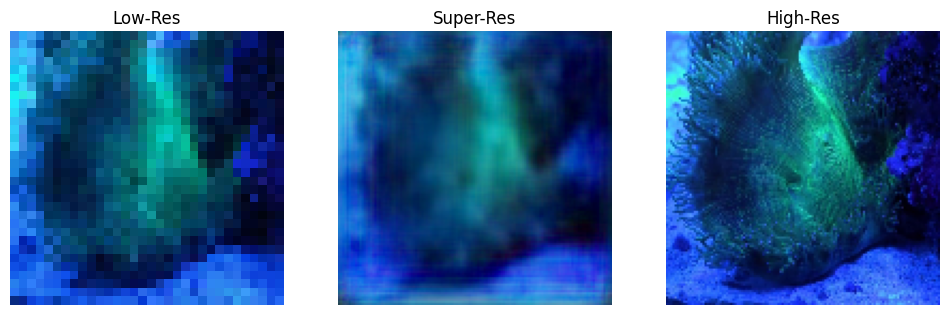

In [ ]:
def visualize_results(idx=0):
    lr_img = X_val_lr[idx:idx+1]
    hr_img = X_val_hr[idx]
    sr_img = generator.predict(lr_img)[0]

    plt.figure(figsize=(12, 4))
    titles = ['Low-Res', 'Super-Res', 'High-Res']
    images = [lr_img[0], sr_img, hr_img]

    for i, img in enumerate(images):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
    plt.show()

visualize_results()

In [11]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR and SSIM
def evaluate_srgan(generator, lr_images, hr_images):
    sr_images = generator.predict(lr_images)

    total_psnr = 0
    total_ssim = 0

    for i in range(len(sr_images)):
        # Convert images to the correct data type for skimage
        sr_img = (sr_images[i] * 255).astype(np.uint8)
        hr_img = (hr_images[i] * 255).astype(np.uint8)

        total_psnr += psnr(hr_img, sr_img)
        # SSIM requires multichannel=True for color images
        # Adjust win_size and specify channel_axis
        total_ssim += ssim(hr_img, sr_img, win_size=3, channel_axis=2)

    avg_psnr = total_psnr / len(sr_images)
    avg_ssim = total_ssim / len(sr_images)

    return avg_psnr, avg_ssim

# Evaluate the generator on the validation set
avg_psnr, avg_ssim = evaluate_srgan(generator, X_val_lr, X_val_hr)

print(f"Average PSNR on validation set: {avg_psnr:.4f}")
print(f"Average SSIM on validation set: {avg_ssim:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 781ms/step
Average PSNR on validation set: 17.7456
Average SSIM on validation set: 0.3539


You've calculated the PSNR and SSIM for your SRGAN model on the validation set. Here's a breakdown of what those numbers mean and how to interpret them:

PSNR (Peak Signal-to-Noise Ratio): This is a common metric for measuring the quality of reconstruction of lossy compression codecs (like the output of your generator). A higher PSNR generally indicates a better quality image, meaning the super-resolved image is closer to the original high-resolution image in terms of pixel values. Your result of 17.7456 is on the lower side for image reconstruction tasks.
SSIM (Structural Similarity Index Measure): This metric assesses the perceived structural similarity between two images. It considers aspects like luminance, contrast, and structure, which often aligns better with human perception of image quality than PSNR. A higher SSIM value indicates a greater structural similarity between the super-resolved image and the original high-resolution image. Your result of 0.3539 is also quite low, suggesting there are significant structural differences between the generated images and the ground truth.
In summary: Both your PSNR and SSIM values are relatively low. This suggests that the current SRGAN model is not performing optimally in generating high-resolution images that are both pixel-accurate and structurally similar to the original high-resolution images.

Factors that could be contributing to these results:

Model Architecture: The current generator or discriminator architecture might need further refinement or complexity.
Training Data: The quality and quantity of your training data can significantly impact performance.
Training Parameters: Hyperparameters like the learning rate, number of epochs, and batch size can influence the training process and final results.
Loss Function: While you're using MSE and binary cross-entropy, exploring other perceptual losses or combining them differently might improve results.
To improve these results, you could consider:

Training for more epochs.
Experimenting with different learning rates.
Adjusting the loss weights in your srgan.compile() function.
Exploring more complex or different generator/discriminator architectures.
Considering additional data augmentation techniques.